In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfl = tfp.layers

print(tf.__version__)
print(tfp.__version__)

TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [2]:
# define some base distribution

normal = tfd.Normal(loc=1., scale=1.)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-09 09:33:41.438495: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-09 09:33:41.438820: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
# sample from the normal distribution
z = normal.sample(1000)

In [12]:
# define the scale and shift constants
scale = 5.
shift = 7. 

In [13]:
# define the scale and shift for the transformations
scale_trans = tfb.Scale(scale)
shift_trans = tfb.Shift(shift) 

In [14]:
shift_and_scale = tfb.Chain([shift_trans, scale_trans]) # scale first and then shift
shift_and_scale

In [15]:
# we can also do the scale and shift in series of scale and shift 

shift_and_scale = shift_trans(scale_trans)
shift_and_scale

In [17]:
# apply the forward transformation
x = shift_and_scale.forward(z)

In [18]:
# test inverse 

tf.norm( z - shift_and_scale.inverse(x) )

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [23]:
# log probabilities are important
# define p(x) = p(z)*|detJ(z)|^-1, or p(z) = p(x)*|detJ(x)|^-1
# define log p(x) = log p(z) - log |detJ(z)|

# ok from this we have 
tf.random.set_seed(43)
log_prob_x = normal.log_prob(z) - shift_and_scale.forward_log_det_jacobian(z, event_ndims=0) # event dims 0 for constant output


In [26]:
# However we can also define through the inverse transform
# log p(x) = log p(f^-1(x)) + log |detJ(f^-1(x))| where f^-1 is the inverse transformation (bijector) - the plus sign since its no inverse of the determinant of the Jacobian

# so lets try

log_prob_x_fr_inv = normal.log_prob( shift_and_scale.inverse(x) ) + shift_and_scale.inverse_log_det_jacobian(x, event_ndims=0)


In [27]:
tf.norm( log_prob_x - log_prob_x_fr_inv)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

## Lets go 2D

In [55]:
normal2d = tfd.MultivariateNormalDiag(loc=[0., 0.], scale_diag=[1., 1.5])

In [56]:
n = 10000
z2d = normal2d.sample(n)
z2d.shape

TensorShape([10000, 2])

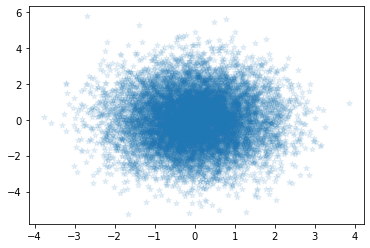

In [57]:
plt.figure()
plt.scatter(z2d[:, 0], z2d[:, 1], alpha=0.1, marker='*')
plt.show()

In [75]:
scale2d = [1.5, 2.]
shift2d = [3., 4.]

In [76]:
scale_trans2d = tfb.Scale(scale2d)
shift_trans2d = tfb.Shift(shift2d)

In [77]:
shift_and_scale2d = shift_trans2d(scale_trans2d)

In [78]:
x2d = shift_and_scale2d.forward(z2d)

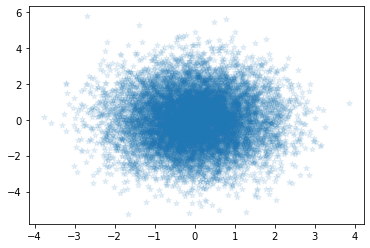

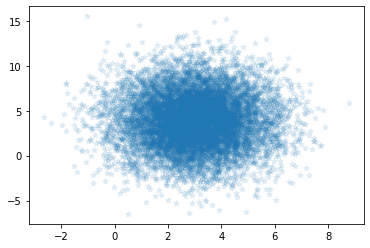

In [79]:
plt.figure()
plt.scatter(z2d[:, 0], z2d[:, 1], alpha=0.1, marker='*')
plt.show()

plt.figure()
plt.scatter(x2d[:, 0], x2d[:, 1], alpha=0.1, marker='*')
plt.show()

In [80]:
cov_z2d = np.cov(z2d.numpy().T)
cov_x2d = np.cov(x2d.numpy().T)
print(cov_z2d)
print(cov_x2d) 

[[ 0.9973529  -0.00385456]
 [-0.00385456  2.22824183]]
[[ 2.24404402 -0.01156369]
 [-0.01156369  8.91296732]]


In [81]:
ratio = np.divide(cov_x2d, cov_z2d)
ratio

array([[2.25      , 3.00000019],
       [3.00000019, 4.        ]])

### the shift operator shifts the mean of the data with shift, the scale scales the (co)variance of the data with (co)variance^2

In [84]:
( (1.5 + 2)/2 )**2

3.0625

In [87]:
# lets try som log probabilities

log_prob_z2d = normal2d.log_prob(z2d)
log_prob_z2d

<tf.Tensor: shape=(10000,), dtype=float32, numpy=
array([-3.2197828, -2.6138935, -5.5280185, ..., -2.8346162, -3.41881  ,
       -2.7239203], dtype=float32)>

In [100]:
# lets check the change of variables in action in 2d

log_prob_x2d = normal2d.log_prob(z2d) - scale_trans2d.forward_log_det_jacobian(z2d, event_ndims=1)

In [101]:
log_prob_z2d

<tf.Tensor: shape=(10000,), dtype=float32, numpy=
array([-4.318395 , -3.7125058, -6.626631 , ..., -3.9332285, -4.517422 ,
       -3.8225327], dtype=float32)>